In [1]:
import json
from collections import Counter, defaultdict
from typing import List, Dict, Union, Callable
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import re
import spacy
import os
import nltk
import logging
import numpy as np
from copy import deepcopy

In [2]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
from sklearn.manifold import TSNE

In [3]:
class Preprocessing:
    """
    This class is performing Review column text pre-processing
    """
    def __init__(self, dataframe: pd.DataFrame):
        """
        :param dataframe: A dataframe which contains a Review column with raw hotel review texts
        """
        self.dataframe = dataframe
        self.preprocessing_operations = []
        
    def remove_quotation_marks(self, quotation_mark_pattern: str="('|´|`|\")"):
        """
        This method takes a quotation mark pattern and removes the quotation marks of the Review column values
        of a Dataframe 
        
        :param quotation_mark_pattern: Regex pattern of quotation marks to be removed 
        
        """
        self.dataframe['Review'] = self.dataframe.Review.apply(lambda x: re.sub(quotation_mark_pattern,"", x))
        self.preprocessing_operations += ['rmv_quotation_marks']
        
    def remove_special_characters(self, special_char_pattern: str='(\x8e|î|æ|±|µ|_|\\|¾|\\||Â|â|é|\x94|«|\x8c|\x81|\x99|\x95|\xa0|©|å|Â|ç|Ù|\x8a|«|¢|~|__Ç_)'):
        """
        This method removes special characters from the Review entries of the dataframe
        
        :param special_chars: List of special characters to be removed from the dataframe        
        
        """                 
            
        self.dataframe['Review'] = self.dataframe.Review.apply(lambda x: re.sub(special_char_pattern,"", x))
        self.preprocessing_operations += ['rmv_special_chars']
    
    def comma_replace_remove_extra_whitespace(self):
        """
        This method replaces commas with whitespace and removes >1 whitespace with a single whitespace in the Review 
        texts        
        """
        
        self.dataframe['Review'] = self.dataframe.Review.apply(lambda x: re.sub(r"( )+"," ", re.sub("(,)", " ", x)).strip())
        self.preprocessing_operations += ['comma_2_whitespace_rmv_extra_whitespace']
               
            
    def __call__(self):
        self.remove_quotation_marks()
        self.remove_special_characters()
        self.comma_replace_remove_extra_whitespace()
        print(f"Preprocessing steps {self.preprocessing_operations}")
        return self.dataframe
            
    def __getitem__(self,item_name):
        if item_name == "dataframe":
            print(f"The following preprocessing operations have been performed {self.preprocessing_operations}")
        return getattr(self, item_name)

In [4]:
def relabel_reviews(review_dataframe: pd.DataFrame, rating_2_sentiment: Dict) -> pd.DataFrame:
    """
    This method performs relabels the review rating column into 3 buckets positive (4+5),
    neutral 3 and negative (1+2)
    
    :param review_dataframe: Dataframe containing a hotel review column and a corresponding rating column
    (1-5)
    :param rating_2_sentiment: Dictionary containing the mapping of the rating to a sentiment score
    
    :return: A Dataframe is returned which contains a normalized_rating column which just contains 3 
    possible sentiment values negative (0), neutral (1) and positive (2)
    """
    
    review_dataframe['norm_rating'] = review_dataframe['Rating'].apply(lambda x: rating_2_sentiment[x])
    
    return review_dataframe    

In [5]:
def get_polarity_dictionary(directory_path: str) -> Dict:
    """
    This method loads a sentiment polarity dictionary based on a root directory path
    
    :param directory_path: Root path to sentiment polarity dictionary
    
    :return: A dictionary with a token as a key and a polarity as a value either 0 if negative or 1 if positive
    """
    polarity_dict = {}
    for file in os.listdir(directory_path):
        if '.tsv' in file:
            f_path = os.path.join(directory_path, file)
            with open(f_path, "r", encoding="utf-8") as f:
                lines = [l.strip() for l in f.readlines()]
            for line in lines:
                split_line = line.split("\t")
                if len(split_line)> 1:
                    polarity_dict[split_line[0]] = float(split_line[1])
    
    return polarity_dict

In [6]:
class TopicModeling:
    """
    This class performs topic modeling on a list of input texts and returns the topic model
    """
    def __init__(self, spacy_model, tokenizer, list_of_texts: List, stop_words: List,
                 punctuation_pattern:str= r"(\.|\?|:|_|,|!|$|%|&|-|=)",
                 pos_tag_include_list=["ADJ", "VERB", "ADV", "NOUNT"],
                 ):
        
        self.spacy_model = spacy_model
        self.stop_words = stop_words
        self.punctuation_pattern = punctuation_pattern
        self.keep_tags=pos_tag_include_list
        self.tokenizer=tokenizer
        self.texts = list_of_texts
        self.index2token_dictionary = {}
        self.tokenized_text = []
        self.lda_model = None
        self.method_list = [self.remove_punctuation,
                            self.remove_stopwords,
                            self.lemmatize_tokens]
        
        
    def normalize_input_text(self, text, *args):
        """
        This method applies a sequence of normalization steps on a text and returns a normalized text
        
        :param txt: Text to be normalized
        
        :return: Normalized Text
        """
        for fun in args:
            text = fun(text)        
        return text

    def remove_punctuation(self, input_text: str):
        """
        This method removes the punctuation of an input text 
        
        :param input_text: Text to be normalized
        
        :return: Text without punctuation
        """
        return re.sub(r"( )+", " ", re.sub(self.punctuation_pattern," ", input_text)).strip()   
    
    
    def remove_stopwords(self, input_text): 
        """
        This method removes stopwords of an input text
        
        :param input_text: Text to be normalized
        
        :return: Text without stopwords
        """
        return ' '.join([tkn for tkn in input_text.split(" ") if tkn not in self.stop_words])
    
    
    def lemmatize_tokens(self, input_text):   
        """
        This method lemmatizes an input text and keeps only a set of tokens corresponding to the 
        defined keep_tag POS tag list
        
        :param input_text: Text to be normalized
        
        :return: Lemmatized text with POS tags of interest        
        """
        return ' '.join([tkn.lemma_ for tkn in self.spacy_model(input_text) if tkn.pos_ in self.keep_tags]) 
  


    def preprocess_text(self, input_text:str):       
        return self.normalize_input_text(input_text, *self.method_list)
    
    def preprocess(self):
        self.texts = [self.preprocess_text(txt) for txt in tqdm(self.texts)]
    
    
    def tokenize_text(self):
        """        
        This method tokenizes the list of texts
        
        :param tokenizer: Tokenizer for word tokenization
        """
        self.tokenized_text =  [self.tokenizer(txt) for txt in self.texts]

    def create_lda_model_dict(self):
        self.tokenize_text()
        self.index2token_dictionary = corpora.Dictionary(self.tokenized_text)        
    
    def token_list_2_lda_corpus(self):
        if not self.index2token_dictionary:
            self.create_lda_model_dict()
        self.corpus = [self.index2token_dictionary.doc2bow(token_array) for 
                       token_array in self.tokenized_text]
        
    def fit_lda_topic_model(self, num_topics: int, random_state: int=42, chunksize:int=100,
                            passes:int=10, alpha:str='auto', **kwargs):
        if not self.corpus:
            self.token_list_2_lda_corpus()            
        
        self.lda_model = gensim.models.ldamodel.LdaModel(
                                                         corpus=self.corpus,
                                                         id2word=self.index2token_dictionary,
                                                         num_topics=num_topics, 
                                                         random_state=random_state,
                                                         chunksize=chunksize,
                                                         passes=passes,
                                                         alpha=alpha,
                                                         **kwargs
                                                         )
    
        return self.evaluate_lda_model()
        
    def evaluate_lda_model(self):
        
        perplexity = self.lda_model.log_perplexity(self.corpus)
        lda_coherence = CoherenceModel(model=self.lda_model,
                                             texts=self.tokenized_text,
                                             dictionary=self.index2token_dictionary,
                                             coherence='c_v')
        lda_coherence_score = lda_coherence.get_coherence()
        return {'log_perplexity': perplexity, 'coherence_score': lda_coherence_score}
        
    def get_topic_vector(self, input_text):       
        
        if self.lda_model:            
            text_indices = self.index2token_dictionary.doc2bow(self.tokenizer(input_text))
            
            topic_number = self.lda_model.num_topics
            topic_vec = np.zeros(topic_number)
            for topic in self.lda_model[text_indices]:
                topic_vec[topic[0]]=topic[1]
            return topic_vec
        else:
            raise("A topic model needs to be trained to get a topic vector")
    
    
    def __call__(self, input_texts):
        if self.lda_model:                                                               
            clean_texts = [self.preprocess_text(txt) for txt in tqdm(input_texts)]                                                               
            return {txt:self.get_topic_vector(indices) for txt, indices in zip(input_texts, clean_texts)}

        else:
            raise("A topic model has to be fitted before this method can be called")
        
        
    
    def __getitem__(self, item_name):
        return getattr(self, item_name)

In [ ]:
class SentimentPolarity:
    """
    This class can be used to compute sentiment polarity score for a input text
    """
    def __init__(self, tokenizer, frequent_word_polarity_dict: Dict, adjective_polarity_dict: Dict):
        self.word_tokenizer = tokenizer
        self.freq_word_polarity = frequent_word_polarity_dict
        self.adj_polarity = adjective_polarity_dict
    
    def __call__(self, input_texts):
        """
        Compute the min, max and mean polarity scores per document for a list of input texts 
        
        :param input_texts: List of input texts for which the polarity scores should be computed
        
        :return: Dataframe which contains that polarity scores as columns and the text as an index
        """
        return pd.concat([self.text_2_polarity_scores(txt) for txt in input_texts], axis=0).set_index("text")
    
    def text_2_polarity_scores(self, input_text: str) -> Dict:
        """
        This method computes the min, max, mean polarity scores for an input text both for adjectives and for 
        frequent words based on polarity dictionaries
        
        :param input_text: Normalized input text for which the polarity scores should be computedd
        
        :return: Dictionary containing the min, max, mean polarity scores both for adjectives and frequent words as well
                 as the text for which these scores where computed
        """
        
        tokenized_text = self.word_tokenizer(input_text)
        adjective_scores = [0]
        freq_word_scores = [0]
        for token in tokenized_text:
            if token in self.freq_word_polarity.keys():
                freq_word_scores.append(self.freq_word_polarity[token])
            if token in self.adj_polarity.keys():
                adjective_scores.append(self.adj_polarity[token])
        
        return pd.DataFrame({
                'text': [input_text],
                'min_adj': [np.min(adjective_scores)],
                'max_adj': [np.max(adjective_scores)],
                'mean_adj':[np.mean(adjective_scores)],
                'min_freq_w':[np.min(freq_word_scores)],
                'max_freq_w': [np.max(freq_word_scores)],
                'mean_freq_w': [np.mean(freq_word_scores)]
                })

In [8]:
review_df = pd.read_csv(r"C:\Users\christoph.hiemenz\Downloads\archive\tripadvisor_hotel_reviews.csv", encoding="utf-8")

In [9]:
Counter(review_df.Rating)

Counter({4: 6039, 2: 1793, 3: 2184, 5: 9054, 1: 1421})

## Dataset desription 

Trip Advisor Hotel Reviews
20k hotel reviews crawled from Tripadvisor.

Alam, M. H., Ryu, W.-J., Lee, S., 2016. Joint multi-grain topic sentiment: modeling semantic aspects for online reviews. Information Sciences 339, 206–223. 

[Kaggle Trip Advisor Reviews](https://www.kaggle.com/andrewmvd/trip-advisor-hotel-reviews)

In [10]:
# Binning of the scores into 2 buckets
# positive 4 & 5
# neutral 3
# negative 1 & 2 

rating_2_sentiment = {1: 0, 2:0, 3:1, 4:2, 5:2}

In [11]:
review_dataframe = relabel_reviews(review_dataframe=review_df, rating_2_sentiment=rating_2_sentiment)

In [12]:
review_dataframe.head()

Review  Rating  norm_rating
0  nice hotel expensive parking got good deal sta...       4            2
1  ok nothing special charge diamond member hilto...       2            0
2  nice rooms not 4* experience hotel monaco seat...       3            1
3  unique, great stay, wonderful time hotel monac...       5            2
4  great stay great stay, went seahawk game aweso...       5            2

In [20]:
review_texts = list(cleaned_dataframe.Review)
review_texts[0]

'nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous reviews did valet parking check quick easy little disappointed non-existent view room room clean nice size bed comfortable woke stiff neck high pillows not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe just noisy neighbors aveda bath products nice did not goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience having pay 40 parking night'

c:\users\christoph.hiemenz\anaconda3\envs\automl_vs_hyperdrive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'Negative'), Text(1, 0, 'Neutral'), Text(2, 0, 'Positive')]

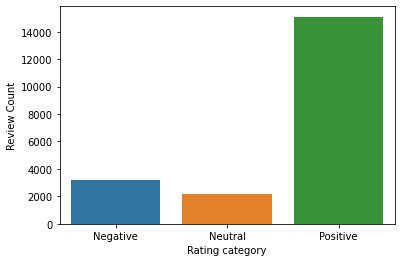

In [191]:
ax = sns.countplot(review_dataframe.norm_rating)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Negative'
labels[1] = 'Neutral'
labels[2] = 'Positive'
plt.xlabel('Rating category')
plt.ylabel('Review Count')
ax.set_xticklabels(labels)

### Print all possible characters to find some special characters which need to be cleaned

In [14]:
Counter([i for j in review_dataframe.Review for i in j]).most_common()

[(' ', 2159240),
 ('e', 1513260),
 ('t', 996584),
 ('a', 972501),
 ('o', 942787),
 ('r', 844888),
 ('i', 818584),
 ('n', 801006),
 ('s', 786985),
 ('l', 693554),
 ('d', 500489),
 ('c', 453111),
 ('u', 332398),
 ('g', 321716),
 ('h', 317789),
 ('p', 312638),
 ('m', 307635),
 (',', 246969),
 ('y', 246715),
 ('f', 242543),
 ('b', 231500),
 ('k', 164506),
 ('w', 163250),
 ('v', 138276),
 ('.', 44415),
 ('x', 41499),
 ('j', 30761),
 ('0', 25650),
 ('q', 22976),
 ('-', 19778),
 ("'", 19710),
 ('1', 19237),
 ('2', 18231),
 ('z', 16328),
 ('_', 15105),
 ('5', 13085),
 ('3', 11509),
 ('4', 8841),
 ('/', 8036),
 ('6', 4781),
 ('7', 4324),
 ('Ç', 4168),
 ('8', 4141),
 ('9', 3313),
 ('é', 3121),
 (':', 2099),
 ('*', 680),
 ('+', 404),
 ('\x8f', 279),
 ('\x96', 255),
 ('î', 245),
 ('\x91', 214),
 ('Ä', 196),
 ('=', 170),
 ('È', 166),
 ('\x9d', 148),
 ('ö', 136),
 ('\x94', 116),
 ('ê', 116),
 ('`', 95),
 ('~', 65),
 ('Ù', 47),
 ('©', 44),
 ('\x8d', 44),
 ('ä', 34),
 ('\x8c', 32),
 ('\x8a', 30),
 ('À

In [15]:
### Apply text preprocessing operations to the Dataframe

In [16]:
special_character_list = ['\x8e','î','æ','±','µ','_','\\','¾','\|', 'Â','â','é','\x94','«','\x8c','\x81','\x99','\x95','\xa0','©','å','Â','ç','Ù','\x8a','«','¢', '~','__Ç_']
special_char_pattern = "("+ '|'.join(special_character_list) + ")"
special_char_pattern

'(\x8e|î|æ|±|µ|_|\\|¾|\\||Â|â|é|\x94|«|\x8c|\x81|\x99|\x95|\xa0|©|å|Â|ç|Ù|\x8a|«|¢|~|__Ç_)'

In [17]:
quotation_mark_pattern = "('|´|`|\")"

In [18]:
preprocessing_obj = Preprocessing(dataframe=review_dataframe)
preprocessing_obj.remove_quotation_marks(quotation_mark_pattern=quotation_mark_pattern)
preprocessing_obj.remove_special_characters(special_char_pattern=special_char_pattern)
preprocessing_obj.comma_replace_remove_extra_whitespace()

In [19]:
cleaned_dataframe = preprocessing_obj['dataframe']

The following preprocessing operations have been performed ['rmv_quotation_marks', 'rmv_special_chars', 'comma_2_whitespace_rmv_extra_whitespace']


In [ ]:
cleaned_dataframe.columns

In [71]:
target_label_df = cleaned_dataframe.loc[:, ['norm_rating']]
target_label_df.index = cleaned_dataframe.Review
target_label_df.index.name = "text"

In [19]:
nlp = spacy.load('en_core_web_md')

In [ ]:
doc = nlp("This is a proper sentences")
for token in doc:
    print(token.pos_)

In [161]:
dataframe_copy = deepcopy(cleaned_dataframe).loc[:, ["Review"]]

In [265]:
dataframe = dataframe_copy

In [266]:
dataframe

Review
0      nice hotel expensive parking got good deal sta...
1      ok nothing special charge diamond member hilto...
2      nice rooms not 4* experience hotel monaco seat...
3      unique great stay wonderful time hotel monaco ...
4      great stay great stay went seahawk game awesom...
...                                                  ...
20486  best kept secret 3rd time staying charm not 5-...
20487  great location price view hotel great quick pl...
20488  ok just looks nice modern outside desk staff n...
20489  hotel theft ruined vacation hotel opened sept ...
20490  people talking ca nt believe excellent ratings...

[20491 rows x 1 columns]

In [256]:
max_len = 200

In [274]:
nlp_transformer("the").vector.shape

(768,)

In [258]:
txt = dataframe.iloc[0]


In [273]:
np.zeros(768,).shape

(768,)

In [276]:
class SpacyEmbedding:
    """
    This class computes the mean Roberta embedding for each Review 
    """
    def __init__(self, spacy_model, max_len):
        self.spacy_model = spacy_model
        self.max_len = max_len
        self.embbedding_dim = len(self.spacy_model("the").vector)
    
    def mean_transformer_embedding(self, input_text):
        try:
            return np.mean(np.vstack([tkn.vector for tkn in self.spacy_model(input_text)][:max_len]), axis=0)
        except:
            return np.zeros(768,)
        
    def embed(self, text_dataframe: pd.DataFrame):
        vector_dict_list = [{f"dim_{ind}": val for ind, val in enumerate(self.mean_transformer_embedding(input_text=txt))} for txt in tqdm(text_dataframe.Review)]
        embedding_df = pd.DataFrame(vector_dict_list)
        embedding_df.index = text_dataframe.Review
        embedding_df.index.name = "text"
        return embedding_df

In [277]:
pd.DataFrame([{'a': 1, 'b':2}, {'a': 3, 'b':4}])

a  b
0  1  2
1  3  4

In [ ]:
# Load an english robertabase transformer model
nlp_transformer = spacy.load('en_trf_robertabase_lg')

In [278]:
spacy_emb = SpacyEmbedding(spacy_model=nlp_transformer, max_len=max_len)

In [279]:
embedded_df = spacy_emb.embed(text_dataframe=dataframe)
embedded_df


  0%|▌                                                                                                              | 102/20491 [00:38<2:26:06,  2.33it/s]


  1%|█                                                                                                              | 205/20491 [01:14<1:37:30,  3.47it/s]


  1%|█▋                                                                                                             | 307/20491 [01:51<1:22:55,  4.06it/s]


  2%|██▏                                                                                                            | 409/20491 [02:45<2:04:01,  2.70it/s]


  3%|██▊                                                                                                            | 513/20491 [03:40<2:13:56,  2.49it/s]


  3%|███▎                                                                                                           | 615/20491 [04:22<1:39:43,  3.32it/s]


  3%|███▉                                                                                                           | 717/20491 [05:02<2:02:26,  2.69it/s]


  4%|████▍                                                                                                          | 820/20491 [05:42<1:20:07,  4.09it/s]


  4%|████▉                                                                                                          | 922/20491 [06:14<1:16:42,  4.25it/s]


  5%|█████▌                                                                                                        | 1025/20491 [06:53<1:25:50,  3.78it/s]


  5%|██████                                                                                                        | 1127/20491 [07:43<1:49:37,  2.94it/s]


  6%|██████▌                                                                                                       | 1229/20491 [08:18<2:14:15,  2.39it/s]


  6%|███████▏                                                                                                      | 1331/20491 [09:11<5:49:37,  1.09s/it]


  7%|███████▋                                                                                                      | 1433/20491 [10:06<2:02:07,  2.60it/s]


  8%|████████▎                                                                                                     | 1537/20491 [11:04<3:34:00,  1.48it/s]


  8%|████████▊                                                                                                     | 1640/20491 [11:42<1:36:27,  3.26it/s]


  9%|█████████▎                                                                                                    | 1742/20491 [12:15<2:21:09,  2.21it/s]


  9%|█████████▉                                                                                                    | 1844/20491 [13:02<2:04:19,  2.50it/s]


  9%|██████████▍                                                                                                   | 1946/20491 [13:37<1:07:30,  4.58it/s]


 10%|██████████▉                                                                                                   | 2049/20491 [14:44<4:08:11,  1.24it/s]


 11%|███████████▌                                                                                                  | 2153/20491 [15:26<2:17:29,  2.22it/s]


 11%|████████████                                                                                                  | 2256/20491 [16:09<2:29:33,  2.03it/s]


 12%|████████████▋                                                                                                 | 2359/20491 [17:02<1:26:40,  3.49it/s]


 12%|█████████████▏                                                                                                | 2463/20491 [17:58<2:17:30,  2.19it/s]


 13%|█████████████▊                                                                                                | 2565/20491 [19:09<5:48:11,  1.17s/it]


 13%|██████████████▎                                                                                               | 2667/20491 [20:41<4:27:08,  1.11it/s]


 14%|██████████████▊                                                                                               | 2770/20491 [21:55<2:31:11,  1.95it/s]


 14%|███████████████▍                                                                                              | 2872/20491 [23:49<5:27:48,  1.12s/it]


 15%|███████████████▊                                                                                             | 2974/20491 [26:34<14:00:14,  2.88s/it]


 15%|████████████████▌                                                                                             | 3076/20491 [29:50<7:42:52,  1.59s/it]


 16%|█████████████████                                                                                             | 3178/20491 [32:13<9:10:04,  1.91s/it]


 16%|█████████████████▌                                                                                            | 3280/20491 [35:07<5:17:50,  1.11s/it]


 17%|██████████████████▏                                                                                           | 3382/20491 [36:04<1:53:59,  2.50it/s]


 17%|██████████████████▋                                                                                           | 3484/20491 [37:08<2:02:54,  2.31it/s]


 18%|███████████████████▎                                                                                          | 3586/20491 [38:53<3:16:02,  1.44it/s]


 18%|███████████████████▊                                                                                          | 3688/20491 [41:17<4:34:34,  1.02it/s]


 18%|████████████████████▎                                                                                         | 3790/20491 [43:07<2:22:32,  1.95it/s]


 19%|████████████████████▉                                                                                         | 3892/20491 [44:48<5:39:45,  1.23s/it]


 19%|█████████████████████▍                                                                                        | 3994/20491 [45:59<1:21:28,  3.37it/s]


 20%|██████████████████████▍                                                                                         | 4096/20491 [46:39<54:43,  4.99it/s]


 20%|██████████████████████▌                                                                                       | 4198/20491 [47:43<1:52:46,  2.41it/s]


 21%|███████████████████████                                                                                       | 4300/20491 [48:12<1:15:39,  3.57it/s]


 21%|███████████████████████▋                                                                                      | 4402/20491 [48:54<1:49:17,  2.45it/s]


 22%|████████████████████████▏                                                                                     | 4504/20491 [49:33<1:05:26,  4.07it/s]


 22%|████████████████████████▋                                                                                     | 4608/20491 [50:09<1:18:38,  3.37it/s]


 23%|█████████████████████████▎                                                                                    | 4710/20491 [50:43<1:22:05,  3.20it/s]


 23%|█████████████████████████▊                                                                                    | 4812/20491 [51:18<1:39:35,  2.62it/s]


 24%|██████████████████████████▍                                                                                   | 4914/20491 [51:56<1:46:38,  2.43it/s]


 24%|██████████████████████████▉                                                                                   | 5016/20491 [52:41<1:28:08,  2.93it/s]


 25%|███████████████████████████▍                                                                                  | 5118/20491 [53:19<1:50:23,  2.32it/s]


 25%|████████████████████████████                                                                                  | 5220/20491 [54:05<1:12:56,  3.49it/s]


 26%|████████████████████████████▌                                                                                 | 5322/20491 [54:45<1:30:36,  2.79it/s]


 26%|█████████████████████████████                                                                                 | 5424/20491 [55:24<1:09:26,  3.62it/s]


 27%|█████████████████████████████▋                                                                                | 5526/20491 [56:04<2:28:43,  1.68it/s]


 27%|██████████████████████████████▏                                                                               | 5628/20491 [56:38<1:33:36,  2.65it/s]


 28%|██████████████████████████████▊                                                                               | 5730/20491 [57:19<1:20:08,  3.07it/s]


 28%|███████████████████████████████▎                                                                              | 5832/20491 [58:05<2:23:07,  1.71it/s]


 29%|███████████████████████████████▊                                                                              | 5934/20491 [58:47<6:31:28,  1.61s/it]


 29%|███████████████████████████████▊                                                                            | 6036/20491 [1:00:00<4:43:49,  1.18s/it]


 30%|████████████████████████████████▎                                                                           | 6138/20491 [1:01:28<2:03:49,  1.93it/s]


 30%|████████████████████████████████▉                                                                           | 6242/20491 [1:02:04<1:06:35,  3.57it/s]


 31%|██████████████████████████████████                                                                            | 6346/20491 [1:02:36<51:01,  4.62it/s]


 31%|██████████████████████████████████                                                                          | 6451/20491 [1:03:05<1:05:58,  3.55it/s]


 32%|███████████████████████████████████▏                                                                          | 6554/20491 [1:03:37<50:15,  4.62it/s]


 32%|███████████████████████████████████                                                                         | 6657/20491 [1:05:15<6:35:16,  1.71s/it]


 33%|███████████████████████████████████▌                                                                        | 6759/20491 [1:07:54<2:12:46,  1.72it/s]


 33%|████████████████████████████████████▏                                                                       | 6861/20491 [1:09:41<7:25:39,  1.96s/it]


 34%|████████████████████████████████████▋                                                                       | 6964/20491 [1:11:31<6:34:36,  1.75s/it]


 34%|█████████████████████████████████████▏                                                                      | 7066/20491 [1:14:24<6:13:15,  1.67s/it]


 35%|█████████████████████████████████████▊                                                                      | 7168/20491 [1:16:26<2:55:09,  1.27it/s]


 35%|███████████████████████████████████████                                                                       | 7272/20491 [1:17:12<49:59,  4.41it/s]


 36%|██████████████████████████████████████▊                                                                     | 7374/20491 [1:18:21<1:32:55,  2.35it/s]


 36%|████████████████████████████████████████▏                                                                     | 7476/20491 [1:19:03<50:36,  4.29it/s]


 37%|███████████████████████████████████████▉                                                                    | 7578/20491 [1:19:42<1:05:56,  3.26it/s]


 37%|████████████████████████████████████████▍                                                                   | 7681/20491 [1:20:39<1:41:28,  2.10it/s]


 38%|█████████████████████████████████████████                                                                   | 7786/20491 [1:21:20<2:31:51,  1.39it/s]


 39%|█████████████████████████████████████████▌                                                                  | 7892/20491 [1:21:56<1:01:30,  3.41it/s]


 39%|██████████████████████████████████████████▏                                                                 | 7997/20491 [1:22:37<1:08:28,  3.04it/s]


 40%|███████████████████████████████████████████▍                                                                  | 8100/20491 [1:23:16<49:00,  4.21it/s]


 40%|████████████████████████████████████████████                                                                  | 8202/20491 [1:23:57<46:01,  4.45it/s]


 41%|███████████████████████████████████████████▊                                                                | 8304/20491 [1:24:30<1:22:13,  2.47it/s]


 41%|████████████████████████████████████████████▎                                                               | 8406/20491 [1:25:03<1:22:53,  2.43it/s]


 42%|█████████████████████████████████████████████▋                                                                | 8508/20491 [1:25:42<53:16,  3.75it/s]


 42%|█████████████████████████████████████████████▍                                                              | 8610/20491 [1:26:15<1:07:06,  2.95it/s]


 43%|██████████████████████████████████████████████▊                                                               | 8712/20491 [1:26:49<56:00,  3.50it/s]


 43%|███████████████████████████████████████████████▎                                                              | 8814/20491 [1:27:35<55:27,  3.51it/s]


 44%|██████████████████████████████████████████████▉                                                             | 8916/20491 [1:28:09<1:06:25,  2.90it/s]


 44%|████████████████████████████████████████████████▍                                                             | 9018/20491 [1:28:44<53:13,  3.59it/s]


 45%|████████████████████████████████████████████████▉                                                             | 9121/20491 [1:29:17<46:24,  4.08it/s]


 45%|████████████████████████████████████████████████▌                                                           | 9223/20491 [1:29:52<1:17:46,  2.41it/s]


 46%|██████████████████████████████████████████████████                                                            | 9325/20491 [1:30:26<37:03,  5.02it/s]


 46%|█████████████████████████████████████████████████▋                                                          | 9427/20491 [1:31:05<1:09:21,  2.66it/s]


 47%|██████████████████████████████████████████████████▏                                                         | 9530/20491 [1:31:37<1:11:23,  2.56it/s]


 47%|██████████████████████████████████████████████████▊                                                         | 9633/20491 [1:32:11<1:31:40,  1.97it/s]


 48%|████████████████████████████████████████████████████▎                                                         | 9735/20491 [1:32:41<59:36,  3.01it/s]


 48%|████████████████████████████████████████████████████▊                                                         | 9837/20491 [1:33:18<52:01,  3.41it/s]


 49%|█████████████████████████████████████████████████████▎                                                        | 9939/20491 [1:34:01<55:31,  3.17it/s]


 49%|█████████████████████████████████████████████████████▍                                                       | 10042/20491 [1:34:46<50:52,  3.42it/s]


 50%|████████████████████████████████████████████████████▉                                                      | 10146/20491 [1:35:25<2:54:26,  1.01s/it]


 50%|██████████████████████████████████████████████████████▌                                                      | 10248/20491 [1:35:58<48:55,  3.49it/s]


 51%|███████████████████████████████████████████████████████                                                      | 10350/20491 [1:36:34<41:09,  4.11it/s]


 51%|███████████████████████████████████████████████████████▌                                                     | 10454/20491 [1:37:09<42:18,  3.95it/s]


 52%|███████████████████████████████████████████████████████                                                    | 10556/20491 [1:37:45<1:09:29,  2.38it/s]


 52%|████████████████████████████████████████████████████████▋                                                    | 10658/20491 [1:38:19<45:18,  3.62it/s]


 53%|█████████████████████████████████████████████████████████▏                                                   | 10760/20491 [1:39:00<50:21,  3.22it/s]


 53%|█████████████████████████████████████████████████████████▊                                                   | 10862/20491 [1:39:40<59:09,  2.71it/s]


 54%|██████████████████████████████████████████████████████████▎                                                  | 10964/20491 [1:40:11<46:04,  3.45it/s]


 54%|█████████████████████████████████████████████████████████▊                                                 | 11066/20491 [1:41:05<1:53:03,  1.39it/s]


 55%|██████████████████████████████████████████████████████████▎                                                | 11168/20491 [1:42:06<1:31:31,  1.70it/s]


 55%|██████████████████████████████████████████████████████████▋                                                | 11249/20491 [1:43:56<3:06:34,  1.21s/it]

["'lovely'", "'hotel'", "'service'", "'ruined'", "'stayed'", "'flamenco'", "'1st'", "'december'", "'05'", "'14th'", "'good'", "'holiday'", "'not'", "'return'", "'hotel'", "'service'", "'absolutely'", "'awful'", "'comments'", "'aspects'", "'hotel'", "'rating'", "'5'", "'roomsthe'", "'rooms'", "'large'", "'plenty'", "'space'", "'beds'", "'comfortable'", "'bathroom'", "'spacious'", "'shower'", "'good'", "'water'", "'pressure'", "'mark'", "'rating'", "'4'", "'buffet'", "'restaurantif'", "'like'", "'fish'", "'love'", "'resort'", "'prepared'", "'live'", "'chicken'", "'rise'", "'lunch'", "'dinner'", "'2'", "'weeks'", "'breakfast'", "'great'", "'rating'", "'2'", "'la'", "'carte'", "'restaurantssteak'", "'house'", "'great'", "'food'", "'no'", "'menu'", "'itÇ'", "'like'", "'tapas'", "'bring'", "'round'", "'different'", "'meats'", "'rice'", "'potatoes'", "'rating'", "'4'", "'mexican'", "'do'", "'nt'", "'rating'", "'0'", "'italian'", "'wouldnÇ'", "'say'", "'food'", "'italian'", "'ok'", "'rating'",


 55%|███████████████████████████████████████████████████████████▎                                               | 11351/20491 [1:45:37<1:17:34,  1.96it/s]


 56%|████████████████████████████████████████████████████████████▉                                                | 11453/20491 [1:46:40<55:56,  2.69it/s]


 56%|█████████████████████████████████████████████████████████████▍                                               | 11555/20491 [1:47:30<41:12,  3.61it/s]


 57%|██████████████████████████████████████████████████████████████                                               | 11657/20491 [1:48:07<46:10,  3.19it/s]


 57%|██████████████████████████████████████████████████████████████▌                                              | 11759/20491 [1:48:46<26:52,  5.41it/s]


 58%|███████████████████████████████████████████████████████████████                                              | 11861/20491 [1:49:32<33:33,  4.29it/s]


 58%|██████████████████████████████████████████████████████████████▍                                            | 11963/20491 [1:50:10<1:16:50,  1.85it/s]


 59%|████████████████████████████████████████████████████████████████▏                                            | 12065/20491 [1:50:51<34:47,  4.04it/s]


 59%|████████████████████████████████████████████████████████████████▋                                            | 12167/20491 [1:51:32<41:28,  3.35it/s]


 60%|█████████████████████████████████████████████████████████████████▎                                           | 12269/20491 [1:52:13<57:17,  2.39it/s]


 60%|█████████████████████████████████████████████████████████████████▊                                           | 12371/20491 [1:52:51<43:42,  3.10it/s]


 61%|█████████████████████████████████████████████████████████████████▏                                         | 12473/20491 [1:53:35<3:42:23,  1.66s/it]


 61%|█████████████████████████████████████████████████████████████████▋                                         | 12575/20491 [1:55:24<3:44:32,  1.70s/it]


 62%|███████████████████████████████████████████████████████████████████▍                                         | 12677/20491 [1:56:54<36:43,  3.55it/s]


 62%|███████████████████████████████████████████████████████████████████▉                                         | 12781/20491 [1:57:31<25:59,  4.95it/s]


 63%|████████████████████████████████████████████████████████████████████▌                                        | 12884/20491 [1:58:07<30:01,  4.22it/s]


 63%|█████████████████████████████████████████████████████████████████████                                        | 12987/20491 [1:59:08<41:28,  3.02it/s]


 64%|█████████████████████████████████████████████████████████████████████▋                                       | 13089/20491 [2:00:22<45:45,  2.70it/s]


 64%|██████████████████████████████████████████████████████████████████████▏                                      | 13191/20491 [2:01:26<55:43,  2.18it/s]


 65%|██████████████████████████████████████████████████████████████████████▋                                      | 13293/20491 [2:02:11<38:53,  3.09it/s]


 65%|███████████████████████████████████████████████████████████████████████▎                                     | 13395/20491 [2:02:45<35:45,  3.31it/s]


 66%|███████████████████████████████████████████████████████████████████████▊                                     | 13499/20491 [2:03:24<39:59,  2.91it/s]


 66%|████████████████████████████████████████████████████████████████████████▎                                    | 13602/20491 [2:03:58<32:32,  3.53it/s]


 67%|████████████████████████████████████████████████████████████████████████▉                                    | 13704/20491 [2:04:58<47:49,  2.37it/s]


 67%|█████████████████████████████████████████████████████████████████████████▍                                   | 13806/20491 [2:05:37<24:29,  4.55it/s]


 68%|█████████████████████████████████████████████████████████████████████████▉                                   | 13908/20491 [2:06:49<45:04,  2.43it/s]


 68%|██████████████████████████████████████████████████████████████████████████▌                                  | 14010/20491 [2:07:32<34:37,  3.12it/s]


 69%|███████████████████████████████████████████████████████████████████████████                                  | 14112/20491 [2:08:16<51:48,  2.05it/s]


 69%|███████████████████████████████████████████████████████████████████████████▌                                 | 14214/20491 [2:09:50<45:18,  2.31it/s]


 70%|██████████████████████████████████████████████████████████████████████████▊                                | 14316/20491 [2:10:36<1:05:45,  1.56it/s]


 70%|████████████████████████████████████████████████████████████████████████████▋                                | 14418/20491 [2:11:17<32:33,  3.11it/s]


 71%|█████████████████████████████████████████████████████████████████████████████▏                               | 14520/20491 [2:12:06<49:21,  2.02it/s]


 71%|█████████████████████████████████████████████████████████████████████████████▊                               | 14622/20491 [2:12:50<51:27,  1.90it/s]


 72%|████████████████████████████████████████████████████████████████████████████▉                              | 14724/20491 [2:14:34<1:57:01,  1.22s/it]


 72%|██████████████████████████████████████████████████████████████████████████████▊                              | 14826/20491 [2:15:56<40:58,  2.30it/s]


 73%|███████████████████████████████████████████████████████████████████████████████▍                             | 14928/20491 [2:16:43<29:20,  3.16it/s]


 73%|██████████████████████████████████████████████████████████████████████████████▍                            | 15030/20491 [2:17:29<1:36:07,  1.06s/it]


 74%|████████████████████████████████████████████████████████████████████████████████▍                            | 15132/20491 [2:18:10<34:32,  2.59it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████                            | 15235/20491 [2:18:53<37:25,  2.34it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████▌                           | 15337/20491 [2:19:33<27:20,  3.14it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████▏                          | 15439/20491 [2:20:22<21:08,  3.98it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████▋                          | 15541/20491 [2:21:20<46:34,  1.77it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 15644/20491 [2:22:09<26:51,  3.01it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████▊                         | 15746/20491 [2:22:53<48:41,  1.62it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 15848/20491 [2:23:48<23:40,  3.27it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████▊                        | 15950/20491 [2:24:42<22:43,  3.33it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████▍                       | 16054/20491 [2:25:23<31:50,  2.32it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 16156/20491 [2:26:15<31:09,  2.32it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████▍                      | 16258/20491 [2:26:57<20:59,  3.36it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████                      | 16360/20491 [2:27:40<21:40,  3.18it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████▌                     | 16462/20491 [2:28:35<30:09,  2.23it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████                     | 16564/20491 [2:29:27<22:23,  2.92it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 16667/20491 [2:30:08<14:31,  4.39it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████▏                   | 16770/20491 [2:30:48<39:31,  1.57it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 16792/20491 [2:31:12<1:43:15,  1.67s/it]

["'punta'", "'cana'", "'princess'", "'not'", "'baby'", "'boyfriend'", "'35'", "'33'", "'visited'", "'punta'", "'cana'", "'princess'", "'march'", "'13'", "'-'", "'19'", "'2007'", "'.'", "'booked'", "'air'", "'hotel'", "'transfers'", "'ta'", "'paid'", "'130'", "'extra'", "'2'", "'upgrade'", "'vip'", "'package'", "'long'", "'review'", "'trip'", "'flights'", "'transfers'", "'flew'", "'air'", "'boston'", "'connected'", "'charlotte'", "'no'", "'problems'", "'flights'", "'transfers'", "'prearranged'", "'vip'", "'travel'", "'no'", "'relation'", "'hotel'", "'quickly'", "'shuttle'", "'no'", "'passengers'", "'drop'", "'arrived'", "'resort'", "'25'", "'minutes'", "'small'", "'traffic'", "'tie'", "'truck'", "'broken'", "'down.check'", "'welcome'", "'bags'", "'unloaded'", "'set'", "'aside'", "'no'", "'waiting'", "'check'", "'walked'", "'right'", "'bartender'", "'lobby'", "'bar'", "'showed'", "'moments'", "'delicious'", "'fruit'", "'punch'", "'served'", "'champagne'", "'glasses'", "'quick'", "'check'


 82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 16793/20491 [2:31:13<1:20:19,  1.30s/it]


appreciated [803]
got [804]
little [805]
extra [806]
attention [807]
saw [808]
superior [809]
service [810]
provided [811]
didnÇ [812]
tip [815]
donÇ [816]
tipped [819]
frequently [820]
like [821]
groundskeepers [822, 823]
beach [824]
cleaners [825]
appreciative [826, 827]
well.as [828, 829, 830]
mentioned [831]
fell [832]
room [833]
actually [834]
hit [835]
head [836]
harder [837]
called [838]
resort [839]
medical [840]
staff [841]
doctor [842]
nurse [843]
room [844]
10 [845]
minutes [846]
ended [847]
agreeing [848]
ambulance [849]
local [850]
clinic [851]
care [852]
fine [853]
clinic [854]
clean [855]
staffed [856]
maybe [857]
not [858]
equipped [859]
x [860]
- [861]
rays [862]
taken [863]
option [864]
cat [865]
scan [866]
declined [867]
aware [868]
need [869]
medical [870]
care [871]
pay [872]
pocket [873]
ambulance [874]
wouldnÇ [875]
roll [878]
resort [879]
paid [880]
155 [881]
clinic [882]
wouldnÇ [883]
taxi [886]
squared [887]
420 [888]
exam [889]
2 [890]
xrays [891, 892]
took [

 82%|█████████████████████████████████████████████████████████████████████████████████████████▉                   | 16897/20491 [2:32:06<16:22,  3.66it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████▍                  | 17000/20491 [2:32:43<35:23,  1.64it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████▉                  | 17104/20491 [2:34:20<55:00,  1.03it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 17118/20491 [2:34:44<3:20:55,  3.57s/it]

["'warning'", "'all'", "'-'", "'read'", "'going'", "'went'", "'bahia'", "'4'", "'-'", "'11'", "'.'", "'felt'", "'important'", "'share'", "'experience'", "'did'", "'read'", "'posts'", "'site'", "'prior'", "'booking.day'", "'1'", "'friday'", "'arrived'", "'hotel'", "'bus'", "'hotel'", "'tags'", "'luggage'", "'tell'", "'ahead'", "'room'", "'luggage'", "'site'", "'realized'", "'room'", "'luggage'", "'voucher'", "'different'", "'room'", "'came'", "'keys'", "'gave'", "'bus'", "'no'", "'check'", "'required'", "'gold'", "'proceeded'", "'room'", "'luggage'", "'tag'", "'walking'", "'20min'", "'no'", "'help'", "'room'", "'tried'", "'key'", "'nothing'", "'walked'", "'20min'", "'2nd'", "'room'", "'key'", "'2'", "'worked'", "'no'", "'luggage'", "'room'", "'called'", "'desk'", "'waited'", "'2'", "'hrs'", "'luggage'", "'came'", "'room'", "'needed'", "'desk'", "'key'", "'safe'", "'pay'", "'walked'", "'grounds'", "'3hrs'", "'finding'", "'right'", "'reception'", "'did'", "'ask'", "'employees'", "'way'", 


 84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 17119/20491 [2:34:44<2:28:52,  2.65s/it]


assist [591]
tried [592]
pool [593]
sit [594]
shade [595]
far [596]
hot [597]
cast [598]
stayed [599]
room [600]
entire [601]
day [602]
apprx [603, 604]
5:00 [605, 606, 607]
called [608]
room [609]
told [610]
friends [611]
stay [612]
4 [613]
days [614]
3 [615]
nights [616]
free [617]
told [618]
given [619]
experience [620]
far [621]
not [622]
stay [623]
plus [624]
confined [625]
room [626]
advised [627]
did [628]
spa [629]
treatments [630]
total [631]
300 [632]
appreciate [633]
settle [634]
told [635]
check [636]
general [637]
manager [638]
hotel [639]
shortly [640]
left [641]
room [642]
7 [643]
pm [644]
al [645]
la [646]
carte [647, 648]
dinner [649]
reservation [650]
no [651]
dinner [652]
went [653]
office [654]
needed [655]
check [656]
check [657]
12hrs [658, 659, 660]
advance [661]
needed [662]
know [663]
told [664]
didnÇ [665]
answer [666, 668]
waited [669]
15min [670, 671]
apparently [672]
talked [673]
manger [674, 675]
told [676]
no [677]
free [678]
stay [679]
asked [680]
conta


 84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 17221/20491 [2:36:45<29:43,  1.83it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████▏                | 17324/20491 [2:37:41<19:13,  2.74it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 17429/20491 [2:38:14<18:11,  2.81it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎               | 17531/20491 [2:38:49<14:38,  3.37it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████▊               | 17634/20491 [2:39:43<23:28,  2.03it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎              | 17739/20491 [2:40:34<18:15,  2.51it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████▉              | 17841/20491 [2:42:12<09:00,  4.90it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍             | 17943/20491 [2:42:58<49:03,  1.16s/it]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████▉             | 18045/20491 [2:44:38<13:18,  3.06it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌            | 18148/20491 [2:45:10<20:53,  1.87it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████            | 18251/20491 [2:45:49<25:05,  1.49it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋           | 18355/20491 [2:46:26<16:58,  2.10it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▏          | 18457/20491 [2:47:10<14:44,  2.30it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋          | 18563/20491 [2:48:15<22:33,  1.42it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 18609/20491 [2:48:59<1:24:51,  2.71s/it]

["'good'", "'choice'", "'felt'", "'compelled'", "'contribute'", "'trip'", "'advisor'", "'valuable'", "'resource'", "'giving'", "'considering'", "'majestic'", "'colonial'", "'booking'", "'trip'", "'hope'", "'review'", "'helps'", "'make'", "'decision'", "'stay'", "'majestic'", "'colonial.my'", "'wife'", "'couple'", "'stayed'", "'8'", "'-'", "'11'", "'-'", "'07'", "'8'", "'-'", "'17'", "'-'", "'07'", "'.'", "'relaxation'", "'trip'", "'opportunity'", "'spend'", "'quality'", "'time'", "'dear'", "'friends'", "'friend'", "'scoured'", "'internet'", "'including'", "'trip'", "'advisor'", "'make'", "'best'", "'decision'", "'sight'", "'unseen'", "'all'", "'-'", "'inclusive'", "'resort'", "'stay'", "'punta'", "'cana'", "'finding'", "'vast'", "'majority'", "'reviews'", "'positive'", "'using'", "'gut'", "'feeling'", "'booked'", "'trip'", "'majestic'", "'colonial'", "'travel'", "'agent'", "'best'", "'deal.first'", "'like'", "'address'", "'unfavorable'", "'reviews'", "'majestic'", "'received'", "'know'


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 18610/20491 [2:49:00<1:03:31,  2.03s/it]


short [710]
comments [711]
areas [712]
beach- [713, 714]
gorgeous [715]
soft [716]
sand [717]
pinkish [718, 719]
color [720]
hold [721]
hand [722]
coral [723]
rock [724]
reef [725]
150 [726]
- [727]
200 [728]
yards [729]
offshore [730]
break [731]
waves [732]
hit [733]
shore [734]
rocks [735]
close [736]
large [737]
easy [738]
spot- [739, 740]
simply [741]
walk [742]
no [743]
means [744]
rock [745]
- [746]
infested [747, 748]
beach [749]
teamÇ [750]
basically [753]
group [754]
fun [755]
- [756]
loving [757]
employees [758]
organize [759]
beach [760]
pool [761]
games [762]
dancing [763]
exercise [764]
routines [765]
fun- [766, 767]
open [768]
- [769]
minded [770]
participate [771]
watch [772]
sidelines [773]
shows [774]
night- [775, 776]
michael [777, 778]
jackson [779, 780]
impersonator [781, 782]
entertaining [783]
fun [784]
hearing [785]
old [786]
songs [787]
seeing [788]
theatrics [789, 790]
didnÇ [791, 794]
catch [794]
shows [795]
rum [796]
lover [797]
prepared [798]
strictly [799


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▌         | 18713/20491 [2:50:57<16:13,  1.83it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████         | 18816/20491 [2:51:46<52:04,  1.87s/it]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 18848/20491 [2:52:22<31:35,  1.15s/it]

["'think'", "'opened'", "'early'", "'ok'", "'sitting'", "'day'", "'paradisus'", "'thought'", "'iÇö'", "'write'", "'review'", "'fresh.the'", "'hotel'", "'40'", "'minutes'", "'airport'", "'hotels'", "'long'", "'bavaro'", "'hotel'", "'strip'", "'noted'", "'hotel'", "'just'", "'opened'", "'dec'", "'05'", "'greenery'", "'grounds'", "'work'", "'progress.from'", "'lobby'", "'direct'", "'view'", "'ocean'", "'central'", "'square'", "'contains'", "'gardenÇ'", "'fountains'", "'entrances'", "'restaurants'", "'casino'", "'theater.for'", "'reason'", "'check'", "'takes'", "'longer'", "'necessary'", "'just'", "'need'", "'guest'", "'info'", "'card'", "'i'", "'d'", "'printed'", "'takes'", "'20'", "'30'", "'minutes'", "'timeÇ'", "'type'", "'experiences'", "'staying'", "'here.the'", "'rooms'", "'hotel'", "'nice'", "'spacious'", "'flat'", "'screen'", "'tv'", "'3'", "'english'", "'channels'", "'flat'", "'panel'", "'cnn'", "'iÇö'", "'decor'", "'bali'", "'-'", "'esque'", "'lots'", "'wood'", "'clean'", "'lines


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 18917/20491 [2:53:07<24:30,  1.07it/s]

["'ocean'", "'blue'", "'excellent'", "'resort'", "'boyfriend'", "'mid-20Ç'", "'stayed'", "'ocean'", "'blue'", "'6'", "'days'", "'week'", "'june'", "'awesome'", "'time'", "'relaxation'", "'beach'", "'ocean'", "'fruity'", "'frosty'", "'drinks'", "'booked'", "'trip'", "'left'", "'read'", "'ocean'", "'blue'", "'reviews'", "'faithfully'", "'little'", "'concerned'", "'negative'", "'reviews'", "'figured'", "'weÇö'", "'think'", "'value'", "'ocean'", "'blue'", "'excellent'", "'booked'", "'hotel'", "'apple'", "'flight'", "'separately'", "'usa3000'", "'ocean'", "'blue'", "'57'", "'day'", "'reading'", "'reviews'", "'main'", "'complaints'", "'time'", "'food'", "'friendliness'", "'staff'", "'travelers'", "'generally'", "'pretty'", "'happy'", "'hotel'", "'/'", "'grounds'", "'pools'", "'/'", "'beach'", "'rooms'", "'drinks'", "'thing'", "'like'", "'note'", "'future'", "'ocean'", "'blue'", "'-'", "'goers'", "'all'", "'-'", "'inclusive'", "'travelers'", "'general'", "'all'", "'-'", "'inclusive'", "'resor


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 18918/20491 [2:53:08<22:00,  1.19it/s]

[706]
not [707]
miss [708]
treats [709]
breakfast [710]
sweet [711]
breads [712, 713]
bacon [714]
good [715]
didnÇ [716]
really [719]
try [720]
stuff [721]
buffet [722]
line [723]
middle [724]
grilled [725]
pineapple [726]
banana [727]
tasty [728]
mimosa [729, 730]
bar [731]
nice [732]
lunch [733]
twice [734]
beach [735]
buffet [736]
basic [737]
food [738]
really [739]
liked [740]
paella [741, 742]
itÇ [743]
good [746]
quick [747]
lunch [748]
eat [749]
beach [750]
enjoyed [751]
main [752]
buffet [753]
really [754]
excellent [755]
pizza [756]
mini [757]
- [758]
sandwiches [759, 760, 761]
rolls [762]
meat [763]
carving [764]
station [765]
tried [766]
little [767]
pasta [768]
/ [769]
rice [770]
dishes [771]
tasty [772]
day [773]
lunch [774]
dish [775]
called [776]
no [777]
joke [778]
boyÇ [779]
looked []
like []
burrito []
sauce []
no []
idea []
knows []
enlighten []
took []
picture []
little []
sign []
saying []
thought []
funny []
not []
big []
fan []
dominican []
desserts []
general []


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 19021/20491 [2:55:02<05:54,  4.15it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 19123/20491 [2:55:41<16:02,  1.42it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 19226/20491 [2:56:20<09:42,  2.17it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 19328/20491 [2:57:02<06:01,  3.22it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 19430/20491 [2:57:31<04:57,  3.57it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 19532/20491 [2:59:28<02:58,  5.37it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 19637/20491 [3:00:03<05:00,  2.85it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████    | 19740/20491 [3:00:37<03:21,  3.72it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 19842/20491 [3:01:17<04:06,  2.64it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████   | 19945/20491 [3:01:53<03:23,  2.68it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 20048/20491 [3:02:53<08:17,  1.12s/it]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████  | 20126/20491 [3:04:24<18:18,  3.01s/it]

["'mixed'", "'feelings'", "'boyfriend'", "'visited'", "'breezes'", "'july'", "'25th'", "'august'", "'1st'", "'22'", "'boyfriend'", "'24'", "'money'", "'paid'", "'trip'", "'canÇ'", "'really'", "'complain'", "'flight'", "'customs'", "'airport'", "'transfer'", "'smooth'", "'luckily'", "'didnÇ'", "'drop'", "'people'", "'resorts'", "'got'", "'straight'", "'resort'", "'arrival'", "'didnÇ'", "'welcome'", "'drink'", "'hellos'", "'check'", "'-'", "'in'", "'really'", "'easy'", "'fast'", "'just'", "'cared'", "'room'", "'change'", "'bathing'", "'suits'", "'room'", "'building'", "'6'", "'view'", "'garden'", "'resort'", "'left'", "'sea'", "'nice'", "'not'", "'complain'", "'room'", "'traveled'", "'places'", "'slept'", "'old'", "'hostels'", "'europe'", "'room'", "'good'", "'compared'", "'rooms'", "'iÇ\\x9de'", "'stayed'", "'necessary'", "'things'", "'room'", "'day'", "'wasnÇ'", "'worried'", "'things'", "'did'", "'didnÇ'", "'surprisingly'", "'bed'", "'comfortable'", "'read'", "'reviews'", "'time'", "'c


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 20229/20491 [3:05:32<01:10,  3.72it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 20331/20491 [3:06:28<03:14,  1.22s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 20434/20491 [3:07:00<00:18,  3.00it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20491/20491 [3:07:31<00:00,  1.82it/s]


dim_0     dim_1  \
text                                                                     
nice hotel expensive parking got good deal stay...  0.006259  0.118762   
ok nothing special charge diamond member hilton... -0.106125  0.066721   
nice rooms not 4* experience hotel monaco seatt... -0.016965  0.117541   
unique great stay wonderful time hotel monaco l... -0.020134  0.125069   
great stay great stay went seahawk game awesome... -0.021420  0.019936   
...                                                      ...       ...   
best kept secret 3rd time staying charm not 5-s... -0.001689  0.023011   
great location price view hotel great quick pla...  0.045521  0.050664   
ok just looks nice modern outside desk staff nt... -0.064989  0.001457   
hotel theft ruined vacation hotel opened sept 1... -0.063610  0.040250   
people talking ca nt believe excellent ratings ... -0.039016  0.101313   

                                                       dim_2     dim_3  \
text                                                                     
nice hotel expensive parking got good deal stay...  0.154434 -0.046843   
ok nothing special charge diamond member hilton...  0.142225 -0.006830   
nice rooms not 4* experience hotel monaco seatt...  0.154060 -0.066173   
unique great stay wonderful time hotel monaco l...  0.121029 -0.149987   
great stay great stay went seahawk game awesome...  0.101936 -0.059843   
...                                                      ...       ...   
best kept secret 3rd time staying charm not 5-s...  0.076350  0.076047   
great location price view hotel great quick pla...  0.131774 -0.274431   
ok just looks nice modern outside desk staff nt...  0.140042 -0.135670   
hotel theft ruined vacation hotel opened sept 1...  0.084338 -0.092920   
people talking ca nt believe excellent ratings ...  0.128822  0.021632   

                                                       dim_4     dim_5  \
text                                                                     
nice hotel expensive parking got good deal stay...  0.084383  0.178872   
ok nothing special charge diamond member hilton...  0.044796 -0.118835   
nice rooms not 4* experience hotel monaco seatt...  0.072612 -0.105945   
unique great stay wonderful time hotel monaco l...  0.009394  0.070902   
great stay great stay went seahawk game awesome...  0.005231 -0.106664   
...                                                      ...       ...   
best kept secret 3rd time staying charm not 5-s... -0.076341  0.027999   
great location price view hotel great quick pla... -0.093690  0.066306   
ok just looks nice modern outside desk staff nt...  0.149159  0.011530   
hotel theft ruined vacation hotel opened sept 1... -0.044518 -0.172389   
people talking ca nt believe excellent ratings ... -0.078549 -0.048512   

                                                       dim_6     dim_7  \
text                                                                     
nice hotel expensive parking got good deal stay... -0.002897 -0.097523   
ok nothing special charge diamond member hilton...  0.042053  0.011126   
nice rooms not 4* experience hotel monaco seatt...  0.024341  0.057952   
unique great stay wonderful time hotel monaco l... -0.037234 -0.056889   
great stay great stay went seahawk game awesome...  0.064987 -0.009413   
...                                                      ...       ...   
best kept secret 3rd time staying charm not 5-s...  0.006668 -0.137139   
great location price view hotel great quick pla...  0.124789 -0.112445   
ok just looks nice modern outside desk staff nt...  0.015875  0.036097   
hotel theft ruined vacation hotel opened sept 1...  0.005816 -0.005878   
people talking ca nt believe excellent ratings ...  0.007503  0.036395   

                                                       dim_8     dim_9  ...  \
text                                                                    ...   
nice hotel expensive parking got good deal st

In [283]:
# Round the floating point values to 4 digits
embedded_df = embedded_df.applymap(lambda x: np.round(x, 4))
embedded_df = reduced
embedded_df.to_pickle(os.path.join(result_path, "spacy_emb.pkl"))

## Compute dictionary based Polarity scores

In [62]:
sentiment_dictionary_directory = r"C:\Users\christoph.hiemenz\Desktop\SentimentDictionaries"
adjective_polarity_dir = os.path.join(sentiment_dictionary_directory, 'socialsent_hist_adj', 'adjectives')
freq_word_polariy_dir = os.path.join(sentiment_dictionary_directory, 'socialsent_hist_freq', 'frequent_words')

adjective_polarity_dictionary = get_polarity_dictionary(directory_path=adjective_polarity_dir)
frequent_word_polarity_dictionary = get_polarity_dictionary(directory_path=freq_word_polariy_dir)

### Polarity distribution of polarity dictionaries

It can be seen that the both the adjective and frequent word polarity scores of the polarity dictionaries tend to be normally distributed

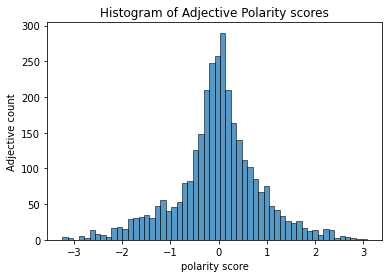

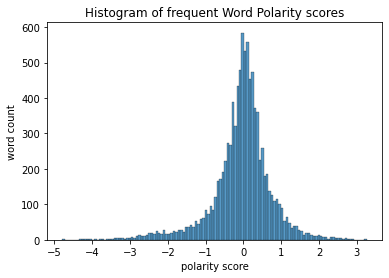

In [83]:
sns.histplot(list(adjective_polarity_dictionary.values()))
plt.title("Histogram of Adjective Polarity scores")
plt.ylabel("Adjective count")
plt.xlabel("polarity score")
plt.show()

sns.histplot(list(frequent_word_polarity_dictionary.values()))
plt.title("Histogram of frequent Word Polarity scores")
plt.ylabel("word count")
plt.xlabel("polarity score")
plt.show()

In [64]:
sentiment_polarity = SentimentPolarity(tokenizer=word_tokenize,
                                       frequent_word_polarity_dict=frequent_word_polarity_dictionary, 
                                       adjective_polarity_dict=adjective_polarity_dictionary)

In [65]:
sentiment_polarity_df = sentiment_polarity(review_texts)

### Visualize the Word Polarity distribution per class label

Both the maximum and mean word polarity scores per document tend to be higher for positive reviews compared to negative reviews

In [ ]:
sentiment_polarity_with_labels = sentiment_polarity_df.join(target_label_df, on="text", how="inner")

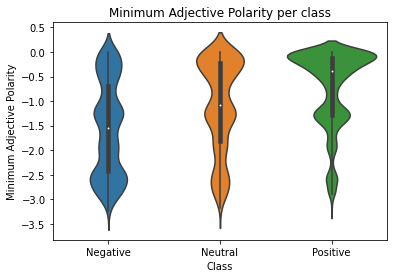

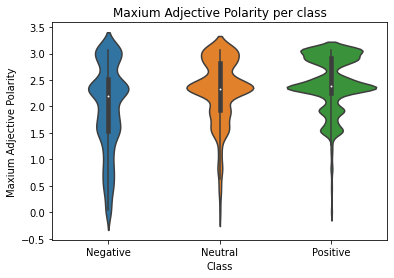

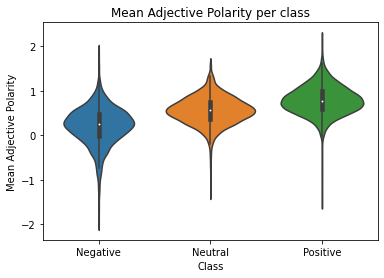

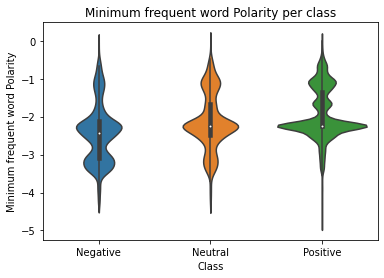

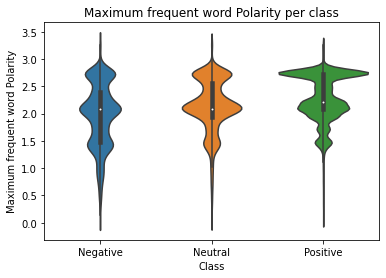

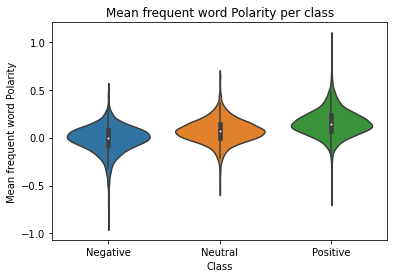

In [81]:
column_2_title_dict = {'min_adj': 'Minimum Adjective Polarity',
                       'max_adj': 'Maxium Adjective Polarity',
                       'mean_adj': 'Mean Adjective Polarity',
                       'min_freq_w': 'Minimum frequent word Polarity',
                       'max_freq_w': 'Maximum frequent word Polarity',
                       'mean_freq_w': 'Mean frequent word Polarity'}

for col in ["min_adj","max_adj","mean_adj", "min_freq_w", "max_freq_w", "mean_freq_w"]:
    ax = sns.violinplot(x="norm_rating", y=col, data=sentiment_polarity_with_labels)    
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[0] = 'Negative'
    labels[1] = 'Neutral'
    labels[2] = 'Positive'
    ax.set_xticklabels(labels)
    plt.title(f"{column_2_title_dict[col]} per class")
    plt.xlabel("Class")
    plt.ylabel(f"{column_2_title_dict[col]}")
    plt.show()

## Feature engineering based on the length of the review 

In [144]:
cleaned_dataframe['review_len'] = cleaned_dataframe.Review.apply(lambda x: len(x.split(" ")))
cleaned_dataframe['log_len'] = cleaned_dataframe.review_len.apply(lambda x: np.log(x))

Text(0.5, 0, 'Token count')

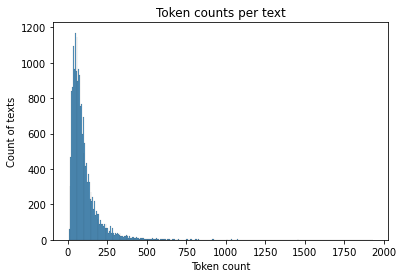

In [156]:
sns.histplot(cleaned_dataframe.review_len)
plt.title("Token counts per text")
plt.ylabel("Count of texts")
plt.xlabel("Token count")

Text(0.5, 0, 'Log token count')

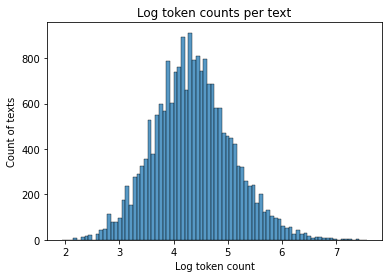

In [147]:
sns.histplot(cleaned_dataframe.log_len)
plt.title("Log token counts per text")
plt.ylabel("Count of texts")
plt.xlabel("Log token count")

In [151]:
high_percentile = np.percentile(cleaned_dataframe.log_len, 95)
low_percentile = np.percentile(cleaned_dataframe.log_len, 5)

In [154]:
cleaned_dataframe['long_review'] = cleaned_dataframe['log_len'].apply(lambda x: 1 if x > high_percentile else 0)
cleaned_dataframe['short_review'] = cleaned_dataframe['log_len'].apply(lambda x: 1 if x < low_percentile else 0)

In [155]:
cleaned_dataframe

Review  Rating  norm_rating  \
0      nice hotel expensive parking got good deal sta...       4            2   
1      ok nothing special charge diamond member hilto...       2            0   
2      nice rooms not 4* experience hotel monaco seat...       3            1   
3      unique great stay wonderful time hotel monaco ...       5            2   
4      great stay great stay went seahawk game awesom...       5            2   
...                                                  ...     ...          ...   
20486  best kept secret 3rd time staying charm not 5-...       5            2   
20487  great location price view hotel great quick pl...       4            2   
20488  ok just looks nice modern outside desk staff n...       2            0   
20489  hotel theft ruined vacation hotel opened sept ...       1            0   
20490  people talking ca nt believe excellent ratings...       2            0   

        log_len  review_len  long_review  short_review  
0      4.465908          87            0             0  
1      5.521461         250            0             0  
2      5.379897         217            0             0  
3      4.488636          89            0             0  
4      5.252273         191            0             0  
...         ...         ...          ...           ...  
20486  4.691348         109            0             0  
20487  3.663562          39            0             0  
20488  4.143135          63            0             0  
20489  6.661855         782            1             0  
20490  4.499810          90            0             0  

[20491 rows x 7 columns]

In [306]:
# Good reviews tend to be short
cleaned_dataframe.groupby("norm_rating").short_review.mean()

norm_rating
0    0.031425
1    0.035714
2    0.051415
Name: short_review, dtype: float64

In [307]:
# Bad reviews tend to be long
cleaned_dataframe.groupby("norm_rating").long_review.mean()

norm_rating
0    0.065339
1    0.059982
2    0.044988
Name: long_review, dtype: float64

In [309]:
review_len_df = cleaned_dataframe.loc[:, ["long_review", "short_review", "norm_rating"]]
review_len_df.index = cleaned_dataframe.Review
review_len_df.index.name = "text"

## Compute Topic vector features

### Topic modeling was performed according to the tutorial at machinelearningplus.com
[https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

In [28]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\christoph.hiemenz\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
english_stop_words = stopwords.words('english')

In [30]:
topic_modeling = TopicModeling(list_of_texts=review_texts, tokenizer=word_tokenize, spacy_model=nlp, stop_words=english_stop_words)
topic_modeling.preprocess()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20491/20491 [09:20<00:00, 36.57it/s]


In [31]:
topic_modeling.token_list_2_lda_corpus()

In [32]:
number_of_topics = 3

In [35]:
# Hyperparameter Grid
topic_number_list = [5,10,15,20,25,30, 40]
chunk_size_list = [100, 200]

In [36]:
topic_grid_search = []
model_list = []
for chunk_size in chunk_size_list:
    for number_of_topics in tqdm(topic_number_list):
        topic_model_results = topic_modeling.fit_lda_topic_model(num_topics=number_of_topics,
                                                                 passes=20,
                                                                 chunksize=chunk_size)
        model_list.append(topic_modeling['lda_model'])
        tmp_df = pd.DataFrame({'num_topics': [number_of_topics],
                               'chunk_size': [chunk_size],
                               'coherence_score': [topic_model_results['coherence_score']],
                               'perplexity_score': [topic_model_results['log_perplexity']]
                               })
        topic_grid_search.append(tmp_df)



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [33:16<00:00, 285.20s/it]


In [37]:
grid_search_results = pd.concat(topic_grid_search, axis=0)

In [42]:
result_path = r"C:\Users\christoph.hiemenz\Desktop\Grid_search_results"

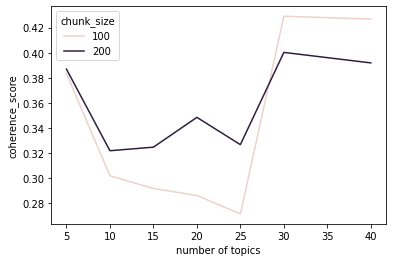

In [44]:
sns.lineplot(x="num_topics", y="coherence_score", data=grid_search_results, hue="chunk_size")
plt.ylabel("coherence_score")
plt.xlabel("number of topics")
plt.savefig(os.path.join(result_path, "coherence_scores.png"), dpi=400)

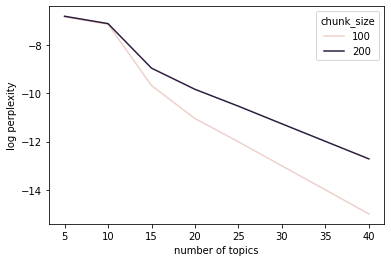

In [45]:
sns.lineplot(x="num_topics", y="perplexity_score", data=grid_search_results, hue="chunk_size")
plt.ylabel("log perplexity")
plt.xlabel("number of topics")
plt.savefig(os.path.join(result_path, "perplexity_scores.png"), dpi=400)

In [41]:
grid_search_results.to_csv(os.path.join(result_path, "lda_grid_result.csv"))

In [50]:
final_model = deepcopy(model_list[5])

In [51]:
final_model

In [92]:
number_of_topics = final_model.num_topics

In [53]:
print(f"The selected model has {final_model.num_topics}")
print(f"The final model used a chunksize of {final_model.chunksize}")

The selected model has 30
The final model used a chunksize of 100


In [ ]:
topic_vector_df = topic_modeling(review_texts)

### Visualize Topic Modeling Results

The word importance plot was generated in a similar way as 
[topic-modeling-visualization-how-to-present-results-lda-models/](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/)

In [56]:
final_model.show_topics(formatted=True, num_topics=number_of_topics, num_words=10)

[(0,
  '0.305*"actually" + 0.147*"white" + 0.106*"fly" + 0.094*"spotless" + 0.069*"usual" + 0.043*"twin" + 0.034*"confirm" + 0.022*"individual" + 0.017*"fashioned" + 0.017*"filthy"'),
 (1,
  '0.321*"hot" + 0.222*"short" + 0.158*"pleasant" + 0.101*"smell" + 0.047*"note" + 0.043*"stick" + 0.020*"unfriendly" + 0.020*"tub" + 0.001*"honor" + 0.000*"disinfectant"'),
 (2,
  '0.257*"different" + 0.174*"stop" + 0.108*"certainly" + 0.067*"easily" + 0.067*"stylish" + 0.064*"home" + 0.059*"best" + 0.046*"outstanding" + 0.038*"exceptional" + 0.020*"invite"'),
 (3,
  '0.176*"appoint" + 0.103*"fall" + 0.098*"somewhat" + 0.088*"deep" + 0.078*"finish" + 0.064*"answer" + 0.059*"step" + 0.054*"concern" + 0.043*"hide" + 0.042*"neat"'),
 (4,
  '0.232*"fabulous" + 0.171*"face" + 0.167*"single" + 0.119*"professional" + 0.076*"immaculate" + 0.061*"accomodating" + 0.025*"generous" + 0.014*"everytime" + 0.011*"inner" + 0.006*"remarkable"'),
 (5,
  '0.115*"quick" + 0.101*"usually" + 0.088*"reasonable" + 0.072*"f

In [95]:
topics = final_model.show_topics(formatted=False, num_topics=number_of_topics, num_words=10)

topic_list = []
for i_th_topic, topic in topics:
    for keyword, word_weight in topic:
        topic_list.append(pd.DataFrame({'word': [keyword], 'topic': [i_th_topic], 'importance': [word_weight]}))
topic_df = pd.concat(topic_list, axis=0)

colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00',
'#cab2d6','#6a3d9a','#ffff99','#b15928','#3f007d','#c7e9b4','#00441b','#d9d9d9',
'#edf8b1','#081d58','#4eb3d3','#1f77b4','#fd8d3c','#ff7f0e','#2ca02c','#d62728',
'#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

In [110]:
plt.close()

In [111]:
for i in range(0,30):
    plt.close()
    selected_topics = topic_indices[previous: i]
    tmp_topic_df = topic_df[topic_df.topic == i]
    sns.barplot(data=tmp_topic_df, x="word", y="importance", color=colors[i])
    plt.title(f"word importance of Topic {i}")
    plt.xlabel("word")
    plt.ylabel("importance score")
    plt.xticks(rotation=90)
    plt.savefig(os.path.join(result_path, "topic_word_importance", f"topic_{i}_word_importance.png"), dpi=400)
    plt.close()
    

In [ ]:
#### Compute a Topic Embeddings for the individual hotel reviews 

In [127]:
len(review_texts)

20491

In [123]:
topic_modeling.lda_model = final_model

In [128]:
review_text_dictionary = topic_modeling(review_texts)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20491/20491 [09:46<00:00, 34.91it/s]


In [129]:
len(review_text_dictionary)

20491

In [139]:
df_list = []
for key, topic_vector in tqdm(review_text_dictionary.items(),total=len(review_text_dictionary)):
    tmp_df = pd.DataFrame({'text': [key]})
    for ind, scalar in enumerate(topic_vector):
        tmp_df[f"topic_{ind}"] = scalar
    df_list.append(tmp_df)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20491/20491 [04:36<00:00, 74.19it/s]


In [140]:
topic_vector_df = pd.concat(df_list, axis=0)

In [295]:
topic_vector_df = topic_vector_df.set_index("text")

In [317]:
topic_vector_df = topic_vector_df.applymap(lambda x: np.round(x, 4))

## Perform character n-gram TFIDF vectorization of the Review Texts

In [21]:
### character-level TFIDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,2)).fit(review_texts)
vocab = vectorizer.vocabulary_
print(f"{len(vocab)} features have been generated")
tfidf_mat = vectorizer.transform(review_texts)

1922

In [22]:
featurized_1.columns

Index(['text', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
       'topic_5', 'topic_6', 'topic_7', 'topic_8',
       ...
       'dim_758', 'dim_759', 'dim_760', 'dim_761', 'dim_762', 'dim_763',
       'dim_764', 'dim_765', 'dim_766', 'dim_767'],
      dtype='object', length=808)

In [25]:
selected_cols = [i for i in featurized_1.columns if "dim_" not in i]

In [38]:
featurized_df_no_embedding = featurized_1.loc[:, selected_cols]

In [43]:
tfidf_df = pd.DataFrame.from_records(tfidf_mat.toarray()).applymap(lambda x: np.round(x,4))
tfidf_col_names = [f"dim_{i}" for i in range(tfidf_df.shape[1])]
tfidf_df.columns = tfidf_col_names
tfidf_df.index = review_texts
tfidf_df.index.name = "text"

In [37]:
tfidf_df.columns

Index(['dim_0', 'dim_1', 'dim_2', 'dim_3', 'dim_4', 'dim_5', 'dim_6', 'dim_7',
       'dim_8', 'dim_9',
       ...
       'dim_1912', 'dim_1913', 'dim_1914', 'dim_1915', 'dim_1916', 'dim_1917',
       'dim_1918', 'dim_1919', 'dim_1920', 'dim_1921'],
      dtype='object', length=1922)

In [47]:
featurized_char_tfidf_df = featurized_df_no_embedding.join(tfidf_df, on="text", how="inner")
featurized_char_tfidf_df.to_csv(os.path.join(result_path, "hotel_reviews_featurized_tfidf.csv"))

## Select among the following features to construct a DataFrame for classification

* polarity scores
* review length
* topic vector
* transformer embeddings
* tfidf embeddings

### 1.) Save a Dataframe which includes Roberta transformer embeddings:

* review length
* polarity scores
* topic vector
* transformer embeddings

In [439]:
featurized_roberta_df = topic_vector_df.join(review_len_df,
                                     on="text", how='inner').join(sentiment_polarity_df,
                                                                  on="text", how="inner").join(embedded_df,
                                                                                               on="text", how="inner")

In [440]:
featurized_roberta_df.to_csv(os.path.join(result_path, "hotel_reviews_featurized_roberta.csv"))

In [ ]:
featurized_df.shape

### 2.) Save a Dataframe which includes character n-gram TFIDF embeddings:

* review length
* polarity scores
* topic vector
* transformer embeddings

In [7]:
featurized_char_tfidf_df = topic_vector_df.join(review_len_df,
                                     on="text", how='inner').join(sentiment_polarity_df,
                                                                  on="text", how="inner").join(tfidf_df,
                                                                                               on="text", how="inner")

### Visualize the Topic Vector Embedding

It can be seen that the Negative class occupies specific subspaces of the topic vector space

In [ ]:
featurized_1 = featurized_roberta_df
topic_cols = [i for i in featurized_1.columns if "topic_" in i]
topic_vec_mat = featurized_1.loc[:, topic_cols]
topic_vec_mat.index = featurized_1.text
topic_vec_mat.index.name = "text"
topic_vec_mat = topic_vec_mat.join(target_label_df, on="text", how="inner")
X = topic_vec_mat.drop(columns=["norm_rating"]).to_numpy()

In [ ]:
# Perform TSNE dimension reduction 
X_embedded = TSNE(n_components=2, n_iter=2500, perplexity=35).fit_transform(X)
topic_tsne = pd.DataFrame.from_records(X_embedded)
topic_tsne.columns = ["TSNE-dim1", "TSNE-dim2"]
topic_tsne["norm_rating"] = list(topic_vec_mat.norm_rating)
l_dict = {0: "Negative", 1: "Neutral", 2: "Positive"}
topic_tsne["norm_rating"] = topic_tsne.norm_rating.apply(lambda x: l_dict[x])
topic_tsne[topic_tsne.norm_rating==2].iloc[0, :]

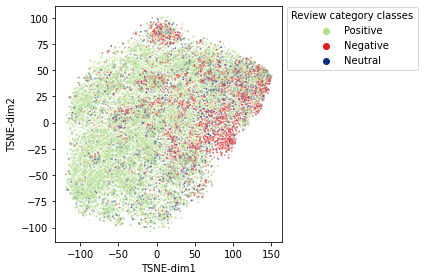

In [214]:
ax = sns.scatterplot(x="TSNE-dim1", y="TSNE-dim2", hue="norm_rating", data=topic_tsne, alpha=0.5, 
                s=3, palette=["#b2df8a","#e41a1c", "#0c2c84"]).legend(
                                                                       bbox_to_anchor=(1, 1.02),
                                                                       title="Review category classes")
plt.tight_layout()
plt.show()

In [ ]:
plt.savefig(os.path.join(result_path, "topic_vector_tsne.png"), dpi=400)